In [24]:
import pandas as pd
import numpy as np
import sklearn
from PIL.GimpGradientFile import linear
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [25]:
data = pd.read_csv("GOOGL.csv", parse_dates=True, index_col=0).dropna()
data.head()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,
2024-01-22,145.462692,0.0,147.854017,145.313225,146.568684,0.0,32200400.0
2024-01-23,146.508896,0.0,146.648390,144.974465,145.363056,0.0,21636100.0
2024-01-24,148.162903,0.0,149.308758,147.565079,148.003477,0.0,25233500.0
2024-01-25,151.321442,0.0,152.497187,148.999856,149.527955,0.0,29149100.0
2024-01-26,151.640289,0.0,151.989016,150.464544,150.554230,0.0,26115500.0


In [26]:
data[data['Stock Splits'] > 0]

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,


No Stock Splits.

In [27]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    """
    Generate lagged features for a specified column
    """
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols

In [28]:
def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)
        df = df.dropna()

    return df

In [29]:
def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Avg_Price'] = (df['Close'] + df['Open']) / 2
    df['Returns'] = np.log(df['Avg_Price'] / df['Avg_Price'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)
    df = df.dropna()
    df = scale_columns(df, 10)
    return df


In [30]:
def stock_train_test_split(df):
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    return train_test_split(df[feature_cols], df[['Target', 'Target_Returns']], test_size=0.3, shuffle=False)


In [31]:
global models
supervised_models = {
    'mlp': sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 70, 50), activation='logistic', max_iter=2000),
    'dt': sklearn.tree.DecisionTreeClassifier(max_depth=5),
    'svm_ln': SVC(kernel='linear'),
    'svm_rbf': SVC(kernel='rbf'),
    'lnr': LinearRegression(),
    'lgr': LogisticRegression(),
    'nb_gs': GaussianNB(),
    'nb_bnl': BernoulliNB()
}

def fit_and_predict_supervised_models(X_train, X_test, y_train, y_test, save_to=None):
    df_result = pd.DataFrame() if not save_to else save_to
    for model_name, model in supervised_models.items():
        model.fit(X_train, y_train['Target'])
        y_test[f'pos_{model_name}'] = model.predict(X_test)
        y_test[f'pos_{model_name}'] = np.sign(y_test[f'pos_{model_name}'])
        y_test[f'pos_{model_name}'] = np.where(y_test[f'pos_{model_name}'] < -0.5, -0.5, y_test[f'pos_{model_name}'])
        df_result[f'ret_{model_name}'] = y_test[f'pos_{model_name}'] * y_test['Target_Returns']
        df_result[f'cum_ret_{model_name}'] = df_result[f'ret_{model_name}'].cumsum()

    df_result['ret_benchmark'] = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = df_result['ret_benchmark'].cumsum()

    for col in df_result.columns:
        if col[:3] != 'cum':
            df_result = df_result.drop(columns=[col])

    return df_result


In [32]:
unsupervised_models = {
    'kmean': KMeans(n_clusters=2),
    'gsmixture': GaussianMixture(n_components=2)
}

def fit_and_predict_unsupervised_models(X_train, X_test, y_train, y_test, save_to=None):
    # Use a new DataFrame or a copy of the provided one
    df_result = pd.DataFrame() if save_to is None else save_to.copy()

    for model_name, model in unsupervised_models.items():
        # Fit the model on training data
        model.fit(X_train)
        predictions = model.predict(X_test)
        signal = np.sign(predictions)
        signal = np.where(signal < -0.5, -0.5, signal)

        ret_original = signal * y_test['Target_Returns']
        cum_ret_original = ret_original.cumsum()

        flipped_signal = -signal
        ret_flipped = flipped_signal * y_test['Target_Returns']
        cum_ret_flipped = ret_flipped.cumsum()

        # Select the alignment with the higher final cumulative return
        if cum_ret_flipped.iloc[-1] > cum_ret_original.iloc[-1]:
            chosen_cum_ret = cum_ret_flipped
        else:
            chosen_cum_ret = cum_ret_original

        # Store the chosen cumulative returns for the model
        df_result[f'cum_ret_{model_name}'] = chosen_cum_ret

    # Compute benchmark cumulative returns
    benchmark_ret = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = benchmark_ret.cumsum()

    # Remove any non-cumulative columns
    for col in list(df_result.columns):
        if not col.startswith('cum'):
            df_result.drop(columns=[col], inplace=True)

    return df_result


In [33]:
data = pd.read_csv("GOOGL.csv", parse_dates=True, index_col=0).dropna()
data = preprocess_data(data)
X_train, X_test, y_train, y_test = stock_train_test_split(data)
df_result = fit_and_predict_supervised_models(X_train, X_test, y_train, y_test)
df_result = fit_and_predict_unsupervised_models(X_train, X_test, y_train, y_test, save_to=df_result)
df_result

,cum_ret_mlp,cum_ret_dt,cum_ret_svm_ln,cum_ret_svm_rbf,cum_ret_lnr,cum_ret_lgr,cum_ret_nb_gs,cum_ret_nb_bnl,cum_ret_benchmark,cum_ret_kmean,cum_ret_gsmixture
Date,,,,,,,,,,,
2024-10-04,-0.013277,0.006639,-0.013277,-0.013277,-0.013277,-0.013277,-0.013277,-0.013277,-0.013277,-0.000000,0.000000
2024-10-07,-0.009666,0.010250,-0.009666,-0.009666,-0.009666,-0.009666,-0.020500,-0.009666,-0.020500,-0.000000,0.000000
2024-10-08,-0.018876,0.014855,-0.018876,-0.018876,-0.018876,-0.018876,-0.029710,-0.005061,-0.029710,-0.009210,0.000000
2024-10-09,-0.026157,0.007574,-0.015235,-0.015235,-0.015235,-0.015235,-0.026070,-0.001420,-0.036991,-0.016491,0.000000
2024-10-10,-0.018691,0.003841,-0.007770,-0.007770,-0.007770,-0.007770,-0.018604,-0.005153,-0.029526,-0.009026,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,0.138551,0.276124,0.444817,0.173516,0.411031,0.468177,0.110868,0.295769,0.143375,0.023879,0.021725
2025-01-10,0.124843,0.262416,0.451671,0.180370,0.417885,0.475031,0.097160,0.302623,0.129666,0.010171,0.021725
2025-01-13,0.125079,0.261944,0.451199,0.179898,0.417413,0.474559,0.096687,0.302859,0.129194,0.009699,0.021725


<Axes: xlabel='Date'>

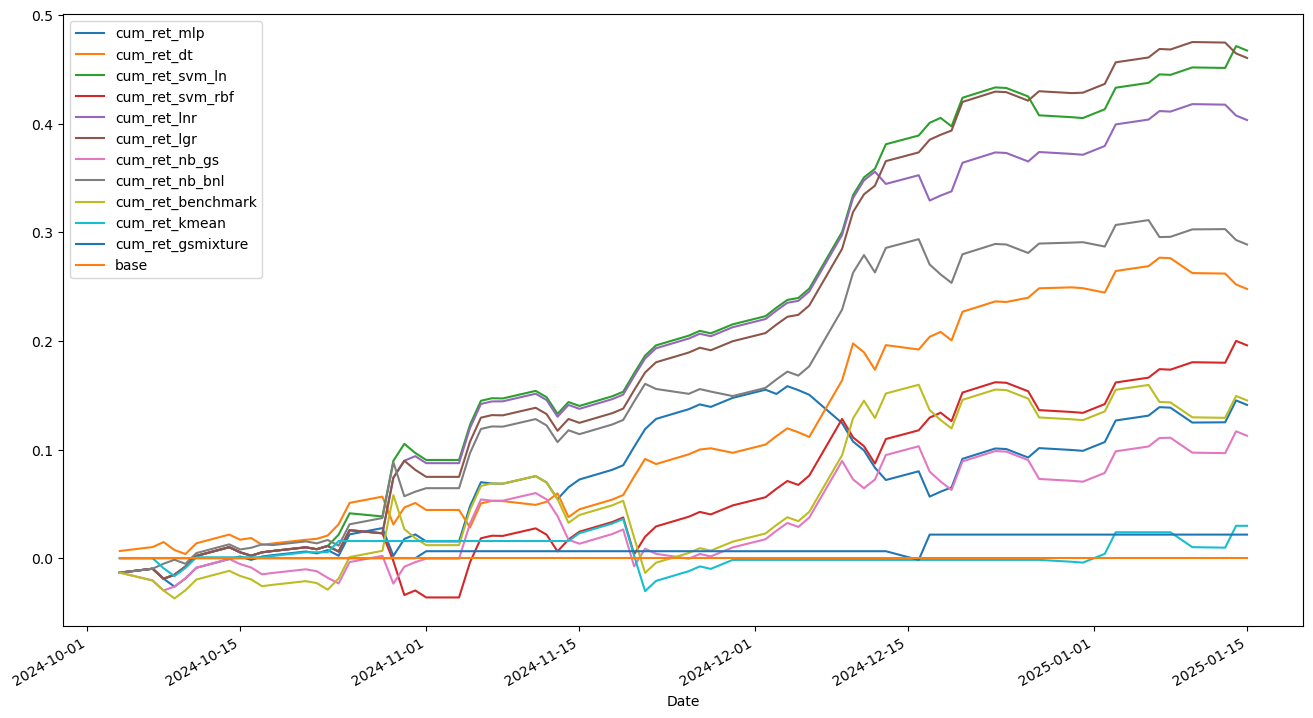

In [34]:
df_result['base'] = np.zeros((len(df_result), 1))
df_result.plot(figsize=(16,9))